# 1.Import libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Set the random seed for generating random numbers, ensuring the results from data generating functions remain the same after each run

In [ ]:
# Set random seed
np.random.seed(21)

# 2.Read Dataset


This notebook uses dataset [Titanic](https://www.kaggle.com/competitions/titanic/data) to build, analyze, and evaluate **Naive Bayes Classifier**.

This dataset has been preprocessed in file `data_preprocessing.ipynb` and separated into 3 files (included in the project): `train.csv`, `val.csv` and `test.csv`.

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Basic ML/datasets/cleaned-data/data_v2/train.csv", index_col="PassengerId")
val_df = pd.read_csv("/content/drive/MyDrive/Basic ML/datasets/cleaned-data/data_v2/val.csv", index_col="PassengerId")

In [ ]:
train_df.head()

,Age,Fare,FamilySize,Pclass,Sex,Embarked,Title_Name,Survived
PassengerId,,,,,,,,
693,25.0,56.4958,1,3,male,S,Mr,1
482,30.0,0.0000,1,2,male,S,Mr,0
528,40.0,221.7792,1,1,male,S,Mr,0
856,18.0,9.3500,2,3,female,S,Mrs,1
802,31.0,26.2500,3,2,female,S,Mrs,1


# 3.Naive Bayes Classifier

Because the dataset contains both categorical features and numerical features. So we will build **Naive Bayes Classifier** by combining two classes from library [scikit-learn](https://scikit-learn.org/1.5/index.html):
- [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) for numerical features.

- [CategoricalNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html) for categorical features.

Then, we will take the average of the prediction probability results of the two models to produce the final prediction.

Identify feature types and target variables.

In [ ]:
categorical_features = ["Pclass", "Sex", "Embarked", "Title_Name"]
numerical_features = ["Age", "Fare", "FamilySize"]

features = categorical_features + numerical_features
target = "Survived"

In [ ]:
# Extract features and Label
X_train_cat = train_df[categorical_features]
X_train_num = train_df[numerical_features]

X_val_cat = val_df[categorical_features]
X_val_num = val_df[numerical_features]

y_train = train_df[target]
y_val = val_df[target]

## 3.1CategoricalNB Model

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
# Define a custom transformer for label encoding
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}

    def fit(self, X, y=None):
        for col in X.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col] = self.label_encoders[col].transform(X[col])
        return X_transformed

In [ ]:
# Create a categorical preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', LabelEncoderTransformer(), categorical_features)
    ])

# Define and Train the CategoricalNB Model on categorical features
cat_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CategoricalNB())
])

cat_nb.fit(X_train_cat, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  LabelEncoderTransformer(),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Title_Name'])])),
                ('classifier', CategoricalNB())])

## 3.2GaussianNB Model

Define and Train the GaussianNB Model on numerical features

In [ ]:
gauss_nb = GaussianNB()
gauss_nb.fit(X_train_num, y_train)

GaussianNB()

## 3.3Make prediction

In [ ]:
# Make prediction probability for each model.
cat_pred = cat_nb.predict_proba(X_val_cat)
gauss_pred = gauss_nb.predict_proba(X_val_num)

In [ ]:
# Average the prediction probabilities of the two models on each class.
final_preds = (cat_pred + gauss_pred) / 2
final_class = np.argmax(final_preds, axis=1)

In [ ]:
print(f"The first element of cat_pred: {cat_pred[0]}")
print(f"The first element of gauss_pred: {gauss_pred[0]}")
print(f"The first element of final_preds: {final_preds[0]}")
print(f"The first element of final_class: {final_class[0]}")

The first element of cat_pred: [0.97336293 0.02663707]
The first element of gauss_pred: [0.74653188 0.25346812]
The first element of final_preds: [0.8599474 0.1400526]
The first element of final_class: 0


In [ ]:
accuracy = accuracy_score(y_val, final_class)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.79


# 4.Evaluate the model

## 4.1Confusion Matrix

In [ ]:
def show_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, normalize: bool=False) -> None:
  """

  """
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(5,5))
  confusion = confusion_matrix(y_true, y_pred)

  axis_labels = range(2)

  if normalize:
    confusion = confusion / confusion.sum(axis=1, keepdims=True)
    ax = sns.heatmap(
        confusion, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.4f', square=True, vmin=0, vmax=1)
  else:
    ax = sns.heatmap(
        confusion, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='d', square=True, vmin=0, vmax=len(y_pred))

  plt.title(f"Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

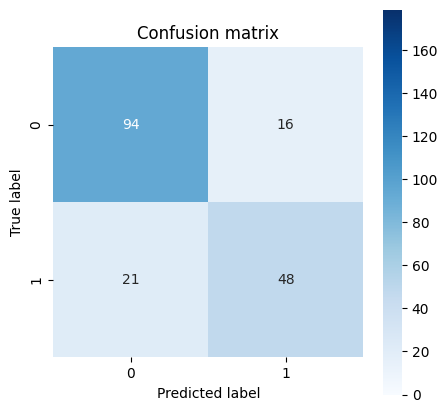

In [ ]:
show_confusion_matrix(y_val, final_class)

**Remarks**
- **True Positives (TP):** 48/69 instances of Class 1 were correctly predicted as Class 1.
- **True Negatives (TN):** 94/110 instances of Class 0 were correctly predicted as Class 0.
- **False Positives (FP):** 16 instances of Class 0 were incorrectly predicted as Class 1 (Type I error).
- **False Negatives (FN):** 21 instances of Class 1 were incorrectly predicted as Class 0 (Type II error).

**Summary:** The model appears better at detecting Class 0 than Class 1 because it is affected by the imbalance between the two classes.

## 4.2Classification Report

In [ ]:
print(classification_report(y_val, final_class))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



**Remarks**

**1. Class-wise performance**
- **Class 0:** The model has strong performance for class 0, with precision, recall, and F1-score all above 0.80.
- **Class 1:**  Performance for class 1 is slightly lower, with precision at 0.75 and recall at 0.70, leading to an F1-score of 0.72. This suggests the model has slightly more difficulty identifying class 1 correctly.

**2. Overall Metrics**
- The overall accuracy of the model is 0.79, meaning 79% of the total predictions are correct.
- The macro average F1-score (0.78) indicates a balanced performance across both classes but is slightly lower than the weighted average due to the class imbalance.
- The weighted average F1-score of 0.79 reflects the performance while accounting for the imbalance in the number of samples in each class.

**Summary:** The model performs well overall, with better results for the majority class (class 0). There is a notable imbalance in the class distribution (110 samples for class 0 and 69 samples for class 1), which might be impacting the recall for class 1.

## 4.3ROC Curve and AUC Scores

AUC: 0.843


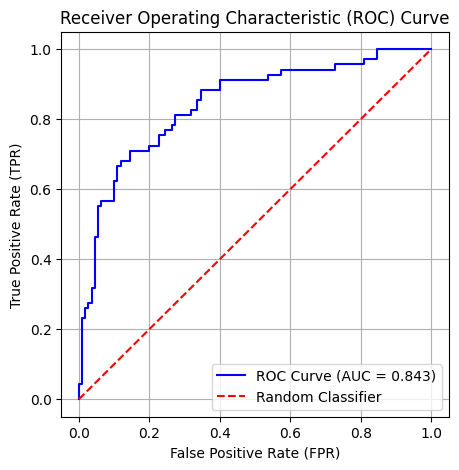

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, final_preds[:, 1]) # final_preds[:, 1]: Predict probabilities for the positive class

# Calculate AUC
auc = roc_auc_score(y_val, final_preds[:, 1])
print(f"AUC: {auc:.3f}")

# Plot ROC Curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

**Remarks:**
- **AUC (Area Under Curve):** The AUC value is 0.843, indicating that the model has a good ability to distinguish between the two classes. A perfect model would have an AUC of 1.0, while a random classifier would have an AUC of 0.5.
- **Shape of the ROC Curve:**
  - The curve is well above the diagonal (random classifier line), showing that the model is significantly better than random guessing.
  - The True Positive Rate (TPR) increases rapidly with a small increase in the False Positive Rate (FPR) at the beginning, which is desirable.

In [ ]:
result_metrics_df = pd.read_csv("/content/drive/MyDrive/Basic ML/source codes/result_metrics.csv")
result_metrics_df

,Model,Accuracy,Precision,Recall,F1-Score
0,CART,0.821229,0.862745,0.637681,0.733333
1,Random Forest,0.815642,0.800000,0.695652,0.744186


In [ ]:
# Save results for comparison between models
from sklearn.metrics import precision_score, recall_score, f1_score

new_row = pd.DataFrame({
    'Model': 'Naive Bayes',
    'Accuracy': accuracy_score(y_val, final_class),
    'Precision': precision_score(y_val, final_class),
    'Recall': recall_score(y_val, final_class),
    'F1-Score': f1_score(y_val, final_class)
}, index=[len(result_metrics_df)])

result_metrics_df = pd.concat([result_metrics_df, new_row], ignore_index=True)

result_metrics_df

,Model,Accuracy,Precision,Recall,F1-Score
0,CART,0.821229,0.862745,0.637681,0.733333
1,Random Forest,0.815642,0.800000,0.695652,0.744186
2,Naive Bayes,0.793296,0.750000,0.695652,0.721805


In [ ]:
result_metrics_df.to_csv('/content/drive/MyDrive/Basic ML/source codes/result_metrics.csv', index=False)